#Imports

In [78]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [79]:
!sudo apt-get install tesseract-ocr-eng  #for english
!sudo apt-get install tesseract-ocr-fas  #for farsi

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr-eng is already the newest version (4.00~git24-0e00fe6-1.2).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr-fas is already the newest version (4.00~git24-0e00fe6-1.2).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [80]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [81]:
!pip install -q tensorflow_addons

In [82]:
!pip install -q Pillow==9.0.0

In [83]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [84]:
import tensorflow as tf
import tensorflow_addons as tfa


from tensorboard.plugins import projector

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import random
import os
import io
import time

import pytesseract
import cv2 

In [85]:
from shutil import copyfile

def copyFile(source , destination):
  open(destination , mode="wb")
  copyfile(source , destination)

In [86]:
def saveCheckpoint(path , model , optimizer):
  checkpoint = tf.train.Checkpoint(model=model , optimizer=optimizer)
  checkpoint.save(path)  

In [87]:
def restoreCheckpoint(path , model , optimizer):
  checkpoint = tf.train.Checkpoint(model=model , optimizer=optimizer)
  checkpoint.restore(tf.train.latest_checkpoint(path))

In [88]:
strategy = None

try:
  resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
  tf.config.experimental_connect_to_cluster(resolver)
  # This is the TPU initialization code that has to be at the beginning.
  tf.tpu.experimental.initialize_tpu_system(resolver)
  print("All devices: ", tf.config.list_logical_devices('TPU'))

  strategy = tf.distribute.TPUStrategy(resolver)
except:
  strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


#Visualizing in Tensorboard

In [89]:
def saveEmbeddings(log_dir , model):
  def tokenize_items(items):
    sequences = tokenizer.texts_to_sequences(items)
    sequences = tf.keras.preprocessing.sequence.pad_sequences(sequences , padding="post")
    return sequences
  
  encodings = {}

  for category in allQuestions:
    for question in allQuestions[category]:
      if question.strip() != "":
        encodings[question] = model(tokenize_items([question]))
  
  if not os.path.exists(log_dir):
    os.makedirs(log_dir)

  with open(os.path.join(log_dir, 'metadata.tsv'), "w") as f:
    for sentence in encodings.keys():
      f.write("{}\n".format(sentence))
  
  weights = np.array(list(encodings.values()))

  weights = tf.Variable(weights[: , 0 , :])

  checkpoint = tf.train.Checkpoint(embedding=weights)
  checkpoint.save(os.path.join(log_dir, "embedding.ckpt"))

  # # Set up config.
  config = projector.ProjectorConfig()
  embedding = config.embeddings.add()

  # The name of the tensor will be suffixed by `/.ATTRIBUTES/VARIABLE_VALUE`.
  embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
  embedding.metadata_path = 'metadata.tsv'
  projector.visualize_embeddings(log_dir, config)

#OCR

In [90]:
import cv2
import numpy as np

# get grayscale image
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# noise removal
def remove_noise(image):
    return cv2.medianBlur(image,5)
 
#thresholding
def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

#dilation
def dilate(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.dilate(image, kernel, iterations = 1)
    
#erosion
def erode(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.erode(image, kernel, iterations = 1)

#opening - erosion followed by dilation
def opening(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

#canny edge detection
def canny(image):
    return cv2.Canny(image, 100, 200)

#skew correction
def deskew(image):
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

#template matching
def match_template(image, template):
    return cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED) 

In [91]:
def convert_image_to_text(path=None , image=None , showImage=False):
  if path != None:
    image = cv2.imread(path)
  
  image = get_grayscale(image)
  image = np.array(thresholding(image))

  if showImage:
    plt.imshow(image)

  config = r'-l fas+eng --psm 6'

  return pytesseract.image_to_string(image , config=config)

#LASM

In [92]:
class LinearAttention(tf.keras.layers.Layer):
  def __init__(self , d_model , heads , dropout=0.1):
    super().__init__()

    assert d_model % heads == 0

    self.d_model = d_model
    self.heads = heads

    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)

    self.wo = tf.keras.layers.Dense(d_model)

    self.dropout = tf.keras.layers.Dropout(dropout)

    self.norm = tf.keras.layers.LayerNormalization(epsilon=1e-6)

  def split_heads(self , items):
    items = tf.reshape(items , shape=(tf.shape(items)[0] , -1 , self.heads , self.d_model//self.heads))
    return tf.experimental.numpy.swapaxes(items , -3 , -2)

  def call(self , query , key , value , mask=None , training=True):

    normedQ = self.norm(query)
    
    q = self.split_heads(self.wq(normedQ))
    k = self.wk(key)
    v = self.wv(value)

    if mask != None:
      k *= mask
      v *= mask
    
    k = self.split_heads(k)
    v = self.split_heads(v)

    transformedQ = tf.nn.elu(q) + 1
    transformedK = tf.nn.elu(k) + 1

    keysSum = tf.reduce_sum(transformedK , axis=-2 , keepdims=True)

    attentionResult = tf.matmul(transformedQ , tf.matmul(transformedK , v , transpose_a=True)) / tf.matmul(transformedQ , keysSum , transpose_b=True)

    attentionResult = tf.reshape(tf.experimental.numpy.swapaxes(attentionResult , -3 , -2) , shape=(tf.shape(attentionResult)[0] , -1 , self.d_model))

    result = self.wo(attentionResult)
    
    result = self.dropout(result , training=training)

    return query + result

In [93]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self , d_model , rate=2 , dropout=0.1):
    super().__init__()

    self.model = tf.keras.Sequential([
                                      tf.keras.layers.LayerNormalization(epsilon=1e-6),
                                      tf.keras.layers.Dense(d_model * rate , activation="gelu"),
                                      tf.keras.layers.Dropout(dropout),
                                      tf.keras.layers.Dense(d_model , activation="gelu"),
                                      tf.keras.layers.Dropout(dropout),
    ])
  
  def call(self , inputs , training=True):
    x = self.model(inputs)
    return inputs + x

In [94]:
class TransformerEncoder(tf.keras.Model):
  def __init__(self , d_model , heads , ffnRate=2 , layers=1 , dropout=0.1):
    super().__init__()
    self.encoders = [(LinearAttention(d_model , heads , dropout) , FeedForward(d_model , ffnRate , dropout)) for _ in range(layers)]

  def call(self , inputs , mask=None , training=True):
    x = inputs

    for (att , ffn) in self.encoders:
      x = att(x , x , x , mask , training)
      x = ffn(x , training)

    return x

In [95]:
class LASM(tf.keras.Model):
  def __init__(self , units , d_model , heads , ffnRate=2 , layers=1 , maxPositions=10000 , dropout=0.1 , usePositionalEncoding=False):
    super().__init__()

    assert d_model // heads

    self.num_of_units = units

    self.d_model = d_model
    self.heads = heads

    self.maxPositions = maxPositions

    self.encoder = TransformerEncoder(d_model , heads , ffnRate , layers , dropout)

    self.units = tf.Variable(tf.keras.initializers.GlorotNormal()(shape=(1 , units , d_model)))
  
    self.usePositionalEncoding = usePositionalEncoding

  def positionalEncoding(self):
    i = np.arange(self.d_model)//2

    encodings = (np.arange(self.maxPositions)[... , np.newaxis]) *  (1 / (np.power(10000 , (2 * i) / self.d_model)))[np.newaxis , ...]

    encodings[: , 0::2] = np.sin(encodings[: , 0::2])
    encodings[: , 1::2] = np.cos(encodings[: , 1::2])

    return encodings[np.newaxis , ...]
  
  def call(self , inputs , mask=None , training=True):
    if self.usePositionalEncoding:
      sequenceLength = tf.shape(inputs)[1]

      if sequenceLength != None:
        inputs += self.positionalEncoding()[: , :sequenceLength , :]

    units  = tf.repeat(self.units , tf.shape(inputs)[0] , axis=0)

    if mask != None:
      mask = tf.concat((tf.ones(shape=(tf.shape(inputs)[0] , self.num_of_units , 1)) , mask) , axis=1)

    inputs = tf.concat((units , inputs) , axis=1)

    encoderResult = self.encoder(inputs , mask , training)
    
    summerizersResult = encoderResult[: , :self.num_of_units , :]

    summerizersResult = tf.reduce_mean(summerizersResult , axis=1) 

    return summerizersResult

#Loading Data

In [96]:
lines = None
with open("/content/gdrive/MyDrive/Examine - CS50x Fair/Dataset.txt" , "r") as f:
  lines = f.readlines()

In [97]:
text = ''.join(lines)

sections = text.split("<Section End>")

allQuestions = {}

listOfQuestions = []

for item in sections:
  header , items = item.split("<Head End>")
  questions = [question.replace("\n" , "").strip() for question in items.split("<end>")]
  allQuestions[header.replace("\n" , "").strip()] = questions
  for _item in questions:
    listOfQuestions.append(_item)

In [98]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token="<UNK>" , filters='')
tokenizer.fit_on_texts(listOfQuestions)

In [99]:
def tokenize(items):
  return tokenizer.texts_to_sequences(items)

def de_tokenize(items):
  return tokenizer.sequences_to_texts(items)

In [100]:
maxLen = max([len(item) for item in tokenize(listOfQuestions)])

In [101]:
questions_1 = []
questions_2 = []
labels = []

negativeCounter = 0
negativePossibility = 6230*[1] + (6230-6230)*[0]
random.shuffle(negativePossibility)

for key_1, value_1 in allQuestions.items():
  for question_1 in value_1:
    for key_2, value_2 in allQuestions.items():
      for question_2 in value_2:
        if question_1 != question_2:
          if key_1 == key_2:
            questions_1.append(tokenize([question_1])[0])
            questions_2.append(tokenize([question_2])[0])
            labels.append(1)
          else:
            if negativePossibility[negativeCounter] == 1:
              questions_1.append(tokenize([question_1])[0])
              questions_2.append(tokenize([question_2])[0])
              labels.append(0)
          
            negativeCounter += 1

In [102]:
questions_1 = tf.keras.preprocessing.sequence.pad_sequences(questions_1 , maxlen=maxLen , padding='post')
questions_2 = tf.keras.preprocessing.sequence.pad_sequences(questions_2 , maxlen=maxLen , padding='post')

In [103]:
questions_1 = np.array(questions_1)[:, np.newaxis, :]
questions_2 = np.array(questions_2)[:, np.newaxis, :]
labels = np.array(labels)[:, np.newaxis]

questions = np.concatenate((questions_1 , questions_2) , axis=1)

In [104]:
print(questions_1.shape)
print(questions_2.shape)
print(labels.shape)

print(questions.shape)

(7826, 1, 71)
(7826, 1, 71)
(7826, 1)
(7826, 2, 71)


In [105]:
trainingData = tf.data.Dataset.from_tensor_slices((questions , labels)).shuffle(len(labels)).batch(256 , drop_remainder=True)

In [106]:
trainingData

<BatchDataset element_spec=(TensorSpec(shape=(256, 2, 71), dtype=tf.int32, name=None), TensorSpec(shape=(256, 1), dtype=tf.int64, name=None))>

#Defining Model and Training

In [107]:
class ExtractorModel(tf.keras.Model):
  def __init__(self , vocab_size):
    super().__init__()
    self.embedding = tf.keras.layers.Embedding(vocab_size , 256 , mask_zero=True)

    self.encoder = LASM(1 , 256 , 4 , 2 , 2)

    self.dense = tf.keras.layers.Dense(256 , activation='gelu')
  
  def make_mask(self , items):
    mask = tf.cast(tf.logical_not(tf.equal(items , 0)) , tf.float32)[... , tf.newaxis]
    return mask

  def call(self , inputs , training=True):
    mask = self.make_mask(inputs)

    x = self.embedding(inputs)
    x = self.encoder(x , mask , training)
    result = self.dense(x)

    return result

In [108]:
class MatcherModel(tf.keras.Model):
  def __init__(self , exctractor , similarityFunction):
    super().__init__()
    self.extractor = exctractor
    self.similarityLayer = tf.keras.layers.Lambda(similarityFunction)

  def call(self , inputs , training=True):
    firstX = inputs[: , 0  , :]
    secondX = inputs[: , 1 , :]

    result_1 = self.extractor(firstX , training=training)
    result_2 = self.extractor(secondX , training=training)

    result = self.similarityLayer([result_1 , result_2])

    return result

In [109]:
import sys

def distance_function(items):
  first = items[0]
  second = items[1]

  distance = tf.reduce_sum(tf.square(first - second) , axis=1 , keepdims=True)

  return distance

In [110]:
with strategy.scope():
  lossObject = tfa.losses.ContrastiveLoss(margin=2.0)
  optimizer = tf.keras.optimizers.Adam()
  metric = tf.keras.metrics.Accuracy()

  vocab_size = len(tokenizer.index_word) + 1

  extractorModel = ExtractorModel(vocab_size)

  model = MatcherModel(extractorModel , distance_function)

  model.compile(loss=lossObject , optimizer=optimizer , metrics=[metric])

  for item in trainingData.take(1):
    model(item[0])

In [111]:
#@title Raw Model Options
restore_model = "Yes" #@param ["Yes", "No"]
restore_checkpoint_path = "/content/gdrive/MyDrive/Examine - CS50x Fair/Raw Checkpoints/" #@param {type:"string"}
saveCheckpoints = "No" #@param ["Yes", "No"]
save_checkpoint_path = "/content/gdrive/MyDrive/Examine - CS50x Fair/Raw Checkpoints/" #@param {type:"string"}


if restore_model.lower() == "yes":
  restoreCheckpoint(restore_checkpoint_path , model , optimizer)

if saveCheckpoints.lower() == "yes":
  saveCheckpoint(save_checkpoint_path , model , optimizer)

saveEmbeddings("/content/gdrive/MyDrive/Examine - CS50x Fair/Embeddings Raw/" , extractorModel)

In [112]:
#@title Training Options
train_model = "No" #@param ["Yes", "No"]

restore_model = "Yes" #@param ["Yes", "No"]
restore_checkpoint_path = "/content/gdrive/MyDrive/Examine - CS50x Fair/Trained Checkpoints/" #@param {type:"string"}

saveCheckpoints = "No" #@param ["Yes", "No"]
save_checkpoint_path = "/content/gdrive/MyDrive/Examine - CS50x Fair/Trained Checkpoints/" #@param {type:"string"}

if restore_model.lower() == "yes":
  restoreCheckpoint(restore_checkpoint_path , model , optimizer)

In [113]:
saveEmbeddings("/content/gdrive/MyDrive/Examine - CS50x Fair/Embeddings Trained/" , extractorModel)

In [ ]:
if train_model.lower() == "yes":
  model.fit(trainingData , epochs=10)

if saveCheckpoints.lower() == "yes":
  saveCheckpoint(save_checkpoint_path , model , optimizer)

saveEmbeddings("/content/gdrive/MyDrive/Examine - CS50x Fair/Embeddings Trained/" , extractorModel)

Epoch 1/10
30/30 [==============================] - 22s 400ms/step - loss: 2.5381 - accuracy: 0.0000e+00
Epoch 2/10
30/30 [==============================] - 12s 400ms/step - loss: 0.7101 - accuracy: 0.0000e+00
Epoch 3/10
30/30 [==============================] - 12s 400ms/step - loss: 0.5161 - accuracy: 0.0000e+00
Epoch 4/10
30/30 [==============================] - 12s 399ms/step - loss: 0.3202 - accuracy: 0.0000e+00
Epoch 5/10
30/30 [==============================] - 12s 400ms/step - loss: 0.1361 - accuracy: 0.0000e+00
Epoch 6/10
30/30 [==============================] - 12s 400ms/step - loss: 0.0864 - accuracy: 0.0000e+00
Epoch 7/10
30/30 [==============================] - 12s 400ms/step - loss: 0.0675 - accuracy: 0.0000e+00
Epoch 8/10
30/30 [==============================] - 12s 401ms/step - loss: 0.0553 - accuracy: 0.0000e+00
Epoch 9/10
30/30 [==============================] - 12s 400ms/step - loss: 0.0550 - accuracy: 0.0000e+00
Epoch 10/10
30/30 [==============================] - 12

#Inference

In [114]:
def get_similar_questions(question , num_of_matches=10):
  firstQuestions = []
  secondQuestions = []

  newMaxLen  = len(tokenize([question])[0])

  newMaxLen = max(newMaxLen , maxLen)

  question = tf.keras.preprocessing.sequence.pad_sequences(tokenize([question]) , maxlen=newMaxLen , padding='post')[0]

  allQuestions = tf.keras.preprocessing.sequence.pad_sequences(tokenize(listOfQuestions) , maxlen=newMaxLen , padding='post')

  for item in allQuestions:
    firstQuestions.append(question)
    secondQuestions.append(item)

  firstQuestions = np.expand_dims(firstQuestions , axis=1)
  secondQuestions = np.expand_dims(secondQuestions , axis=1)

  final_items = np.concatenate((firstQuestions , secondQuestions) , axis=1)

  result = np.squeeze(model(final_items) , axis=-1)

  matches = np.argpartition(result, num_of_matches)[:num_of_matches]

  matchedItems = np.squeeze(secondQuestions[matches , :] , axis=1)

  matchedItems = de_tokenize(matchedItems)

  final_questions = []

  for item in matchedItems:
    final_questions.append(str(item).replace("<UNK>" , "").strip())
  
  return final_questions , ''.join([item + "\n" if item.strip() != "" else "" for item in final_questions])

In [115]:
#@title Question Matcher With Text { vertical-output: true }
Question = "\u0686\u0646\u062F\u0645\u064A\u0646 \u062C\u0645\u0644\u0647 \u0627\u0632 \u062F\u0646\u0628\u0627\u0644\u0647 \u062D\u0633\u0627\u0628\u06CC ... \u0648 8 \u0648 5 \u0648 2 \u0628\u0631\u0627\u0628\u0631 56 \u0627\u0633\u062A \u061F" #@param {type:"string"}
NumOfMatches =  10#@param {type:"integer"}
questionsList , result = get_similar_questions(Question , num_of_matches=NumOfMatches)
print(result)

در یک دنباله حسابی مجموع سه جمله اول و سه جمله آخر ۲۴۰ است. اگر مجموع همه جملات دنباله برابر ۵۲۰ باشد، این دنباله چند جمله دارد؟
مجموع اعداد طبیعی از ۱ تا ۲۰ کدام است؟‌
در بیست جمله اول از یک دنباله حسابی، مجموع جملات ردیف فرد ۱۳۵ و مجموع جملات ردیف زوج ۱۵۰ است. جمله اول کدام است؟
مجموع ۱۰ جمله اول یک دنباله حسابی برابر ۲۵ است. به هر یک از جمله ها ۶ واحد اضافه کرده و سپس در ۲ ضرب کرده و در پایان ۳ واحد از هر یک کم می کنیم. مجموع ۱۰ جمله اول دنباله حاصل کدام است ؟‌
مجموع اعداد طبیعی فرد، بخش پذیر بر ۳ و کوچک تر از ۱۰۱ کدام است؟
در دنباله حسابی ... ۵٫۸٫۱۱٫ حداقل چند جمله باید با هم جمع شوند تا حاصل از ۵۰۰ بیشتر شود؟
مجموع همه اعداد طبیعی دورقمی که مضرب ۶ هستند، کدام است؟
در یک دنباله حسابی ، جمله هفتم نصف جمله سوم است. مجموع چند جمله اول از این دنباله ،‌ صفر است ‌؟‌
در یک دنباله حسابی ،‌ جلمه اول برابر ۵ و هر جمله از جمله ما قبل خود به اندازه ۱/۲ کم تر است. مجموع ده جمله اول آن کدام است؟
اگر مجموع چهار جمله اول یک دنباله حسابی ۲ واحد از مجموع سه جمله اول بیشتر و ۵ واحد از مجموع پنج جمله 


تعداد جملات یک دنباله هندسی عددی زوج است. اگر مجموع تمام جملات آن ۳ برابر مجموع جملات با ردیف فرد باشد، قدرنسبت آن کدام است؟
در یک دنباله حسابی جمله n ام به صورت an = ۳/۲n-5 است. مجموع ۱۵ جمله اول این دنباله ، کدام است ؟
مجموع پنج جمله اول دنباله هندسی ۳۶٫۱۸٫۹٫۰۰۰ کدام است؟
اگر در خانه اول شطرنج ۱ گندم، در خانه دوم ۲ گندم، در خانه سوم ۴ گندم و به همین ترتیب در هر خانه دو برابر خانه قبل، گندم قرار دهیم، اولین خانه ای که مجموع تعداد گندمها تا آن خانه بیشتر از ۴۱۰۰ خواهد بود، کدام است؟
مجموع چند جمله دنباله هندسی ... ۱۲٫۲۴٫ -۶٫ برابر ۱۰۲۶ است؟
در یک دنباله هندسی با قدرنسبت مثبت، مجموع جملات سوم و ششم برابر ۱۴ و تفاضل جملات سوم و نهم برابر ۹۸ است. مجموع چهار جمله اول کدام است؟
بین دو عدد ۳۲۴ و ۴، سه عدد چنان درج شده است که پنج عدد حاصل تشکیل یک دنباله هندسی دهند. مجموع این ۵ عدد مثبت کدام است؟
در یک دنباله هندسی، مجموع ۸ جمله اول ۴۸ و مجموع جملات شروع از جمله چهارم و ختم به جمله یازدهم برابر ۲۴۰ است. قدرنسبت دنباله کدام است؟



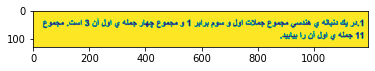

In [116]:
#@title Question Matcher With Image{ vertical-output: true }
ImagePath = "/content/gdrive/MyDrive/Examine - CS50x Fair/Image.png" #@param {type:"string"}
NumOfMatches =  10#@param {type:"integer"}

Question = convert_image_to_text(path=ImagePath , showImage=True)
print()

questionsList , result = get_similar_questions(Question , num_of_matches=NumOfMatches)
print(result)

#Visualization

In [ ]:
%tensorboard --logdir /content/gdrive/MyDrive/Examine - CS50x Fair/Embeddings Raw

ERROR: Failed to launch TensorBoard (exited with 2).
Contents of stderr:
usage: tensorboard [-h] [--helpfull] [--logdir PATH] [--logdir_spec PATH_SPEC]
                   [--host ADDR] [--bind_all] [--port PORT]
                   [--reuse_port BOOL] [--load_fast {false,auto,true}]
                   [--extra_data_server_flags EXTRA_DATA_SERVER_FLAGS]
                   [--grpc_creds_type {local,ssl,ssl_dev}]
                   [--grpc_data_provider PORT] [--purge_orphaned_data BOOL]
                   [--db URI] [--db_import] [--inspect] [--version_tb]
                   [--tag TAG] [--event_file PATH] [--path_prefix PATH]
                   [--window_title TEXT] [--max_reload_threads COUNT]
                   [--reload_interval SECONDS] [--reload_task TYPE]
                   [--reload_multifile BOOL]
                   [--reload_multifile_inactive_secs SECONDS]
                   [--generic_data TYPE]
                   [--samples_per_plugin SAMPLES_PER_PLUGIN]
                   [-

In [ ]:
%tensorboard --logdir "/content/gdrive/MyDrive/Examine - CS50x Fair/Embeddings Trained"

Launching TensorBoard...